# Detecting objects in RGB and Projecting Bounding Boxes

In [ ]:
import os

# Loading some modern detector networks from tfhub produces 
# a lot if spammy warnings that doesn't matter in this notebook.
# Disable them.
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw, ImageFont
from scipy import stats

import tensorflow as tf
import tensorflow_hub as tfhub
tf.get_logger().setLevel('ERROR')


from radicalsdk.h5dataset import H5DatasetLoader
from radicalsdk.radar.config_v1 import read_radar_params
from radicalsdk.radar.v1 import RadarFrame
from radicalsdk.radar import v1_constants
from radicalsdk.geometry import PolarToCartesianWarp


# Read config and configure RadarFrame object
radar_config = read_radar_params('../samples/indoor_human_rcs.cfg')
rf = RadarFrame(radar_config)
data = H5DatasetLoader('../samples/indoor_sample_50.h5')


# Use one of the SOTA object detectors on tfhub
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"

#detector = tfhub.load(module_handle).signatures['default']
detector = tfhub.load("https://tfhub.dev/tensorflow/efficientdet/d6/1")

## Projection Helpers

In [ ]:
def to_cartesian_radar_pixel_coords(world_coords, max_range, n_bins, obj_depth=0.7):
    normalized_wc = world_coords.copy()
    normalized_wc[:2] = normalized_wc[:2]/max_range
    depth_pad = np.array([[0, obj_depth/2, 0],]).T/max_range
    width_pad = np.array([[obj_depth/2, 0, 0],]).T/max_range
    #normalized_wc = np.concatenate([normalized_wc - depth_pad, normalized_wc + depth_pad], axis=1)

    obj_center_estimate = np.mean(normalized_wc, axis=1, keepdims=True)
    normalized_wc = np.concatenate([obj_center_estimate+width_pad,
                                    obj_center_estimate-width_pad,
                                    obj_center_estimate+depth_pad,
                                    obj_center_estimate-depth_pad],
                                   axis=1)

    f = np.array([[n_bins, 0, n_bins],
                  [0, -n_bins, n_bins],
                  [0, 0, 1.]])
    return (f @ normalized_wc)[:2]


def get_depth_estimate(depth_frame, ymin, xmin, ymax, xmax, depth_scale=0.001,
                       method='mode', **kwargs
                      ):
    frame_under_test = depth_frame[ymin:ymax, xmin:xmax] * depth_scale

    if method == 'mode':
        frame_under_test = frame_under_test[frame_under_test != 0]  # get rid of depth = 0 instances
        vals, freqs = stats.mode(frame_under_test)

        if freqs[0] == 1:  # no mode found
            vals, freqs = stats.mode(np.round(frame_under_test, 2))  # round one place away and try again
            if freqs[0] == 1:  # still no mode found
                return np.mean(vals)
        return vals[0]
    elif method == 'bottom_mean':
        return np.mean(frame_under_test[-1])
    elif method == 'center_mean':
        h, w = frame_under_test.shape
        return np.mean(frame_under_test[h//2-2:h//2+2, 4:-5])
    else:
        raise NotImplementedError
        
def get_radar_bounding_square(ymin, xmin, ymax, xmax, depth, P, F,
                              polar=False,
                              max_range=1,
                              n_bins=1,
                              float_coords=True,
                              **kwargs
                             ):
    y_mean = 720 - (ymin+ymax)/2
    points = np.array([[  xmin,     xmax],
                       [y_mean,   y_mean],
                       [     1,        1]])

    #points = np.array([[(xmin+xmax)/2], [(ymin+ymax)/2], [1]])
    world_coords = np.ones([4,2])
    world_coords_unscaled = (np.linalg.inv(F) @ points)
    world_coords_unscaled /= world_coords_unscaled[-1]
    world_coords[:3] = depth*world_coords_unscaled

    # Switching the Y and Z axis just as in the calibration because the radar observes depth directly
    y_row = world_coords[1].copy()
    z_row = world_coords[2].copy()
    world_coords[1] = z_row
    world_coords[2] = 1 # y_row

    radar_coords = P @ world_coords
    radar_coords /= radar_coords[-1]
    #debug(radar_coords)
    if polar:
        angles = (np.arctan(radar_coords[0]/radar_coords[1])*180/np.pi)#.astype(int)
        ranges = (np.linalg.norm(radar_coords[:2], axis=0))#.astype(int)
        #debug(angles, ranges)
        (xmin, xmax, ymin, ymax) = pad_radar_bounds(angles, ranges)
    else:
        pixel_coords = to_cartesian_radar_pixel_coords(radar_coords, max_range, n_bins)
        xmin, ymin = np.min(pixel_coords, axis=1)
        xmax, ymax = np.max(pixel_coords, axis=1)
        #debug(pixel_coords)

    if not float_coords:
        (xmin, xmax, ymin, ymax) = map(round, (xmin, xmax, ymin, ymax))

    return {'xmin': xmin, 'xmax': xmax, 'ymin': ymin, 'ymax': ymax}

def project_bounding_boxes(detections,
                           depth_frame,
                           calibration_constants=v1_constants.TupperwearD435,
                           radar_frame=rf,
                           method='center_mean'
                          ):
    p_matrix = calibration_constants.P
    f_matrix = calibration_constants.F
    
    max_range = rf.max_range
    n_bins = rf.range_nbins
    
    for det in detections:
        depth_est = get_depth_estimate(depth_frame=depth_frame, 
                                       method=method, 
                                       **det)
        rbs = get_radar_bounding_square(
            depth=depth_est,
            P=p_matrix, F=f_matrix,
            max_range=max_range,
            n_bins=n_bins,
            **det,
        )
        
        rbs['class_id'] = det['class_id']
        yield rbs

## Detection helpers

In [ ]:
 def to_results_dict(raw_results, threshold=0.3, width=1, height=1,
                    filter_ids = [1]
                   ):
    scores = raw_results['detection_scores'][0]
    class_id = raw_results['detection_classes'][0]
    boxes = raw_results['detection_boxes'][0]

    for s, i, b in zip(scores, class_id, boxes):
        if filter_ids is not None:
            if i in filter_ids and s > threshold:
                ymin, xmin, ymax, xmax = b
                #debug(b)
                yield {'xmin': round(float(xmin)*width),
                       'xmax': round(float(xmax)*width),
                       'ymin': round(float(ymin)*height),
                       'ymax': round(float(ymax)*height),
                       'class_id': int(i)
                      }
        else:
            if s > threshold:
                ymin, xmin, ymax, xmax = b
                #debug(b)
                yield {'xmin': round(float(xmin)*width),
                       'xmax': round(float(xmax)*width),
                       'ymin': round(float(ymin)*height),
                       'ymax': round(float(ymax)*height),
                       'class_id': int(i)
                      }

def detect_and_filter(img, detector, convert_to_float=False, filter_ids=None, threshold=0.3):
    if convert_to_float:
        raw_results = detector(tf.image.convert_image_dtype(img[np.newaxis, ..., ::-1], dtype=tf.float32))
    else:
        raw_results = detector(img[np.newaxis, ..., ::-1])
    h, w, _ = img.shape
    filtered_boxes = list(to_results_dict(raw_results, width=w, height=h, filter_ids=filter_ids, threshold=threshold))
    return filtered_boxes, raw_results

## Visualization helpers

In [ ]:
def draw_box_single(image, box, display_str, font=None, show_labels=True):
    draw = ImageDraw.Draw(image)
    if font is None:
        font = ImageFont.load_default()
    
    x0, x1, y0, y1 = box['xmin'], box['xmax'], box['ymin'], box['ymax']
    
    # draw the box
    draw.line([(x0, y0), (x1, y0), (x1, y1), (x0, y1), (x0, y0)], 
              width=2, fill='yellow')
    
    if show_labels:
        #compute text string size on image
        text_width, text_height = font.getsize(display_str)
        margin = np.ceil(text_height * 0.05)

        #text label background
        draw.rectangle([(x0, y0-text_height+margin), (x0+text_width, y0)], fill='yellow')
        draw.text([x0+margin, y0-text_height+margin], display_str, fill='black')
    
    
def draw_boxes(image, filtered_results, show_labels=True):
    image_draw = Image.fromarray(image).convert('RGB')
    
    try:
        font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                                  25)
    except IOError:
        print("Font not found, using default font.")
        font = ImageFont.load_default()

    for box in filtered_results:
        draw_box_single(image_draw, box, display_str=f'id: {box["class_id"]}', font=font, show_labels=show_labels)
        
    return image_draw



In [ ]:
p2c = PolarToCartesianWarp()

def p2c_single(img):
    return p2c(img[np.newaxis, ..., np.newaxis])[0, ..., 0]

def to_rgb_heatmap(beamformed_radar, transform_fn=None):
    cmap = plt.get_cmap()
    img = np.log(np.abs(beamformed_radar))
    if transform_fn:
        img = transform_fn(img)
    scaled = img - np.nanmin(img[img != -np.inf])
    scaled = scaled / np.nanmax(scaled[scaled != np.inf])
    rgba_img = cmap(scaled)
    rgb_img = np.delete(rgba_img, 3, 2)
    rgb_img = (rgb_img*255).astype(np.uint8)
    return rgb_img

In [ ]:
FRAME_IDX = 5

filtered_boxes, raw_results = detect_and_filter(data['rgb'][FRAME_IDX], detector, filter_ids=[1])

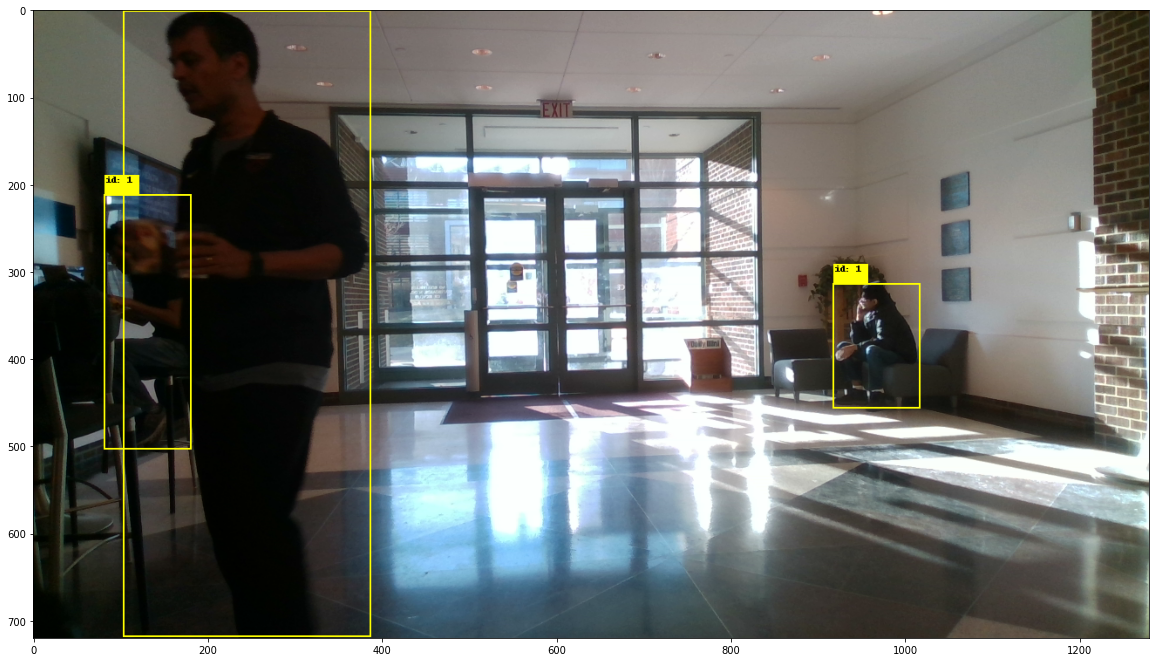

In [ ]:
annotated_image = draw_boxes(data['rgb'][FRAME_IDX][..., ::-1], filtered_boxes)
plt.figure(figsize=(20,15))
plt.imshow(annotated_image)
plt.show()

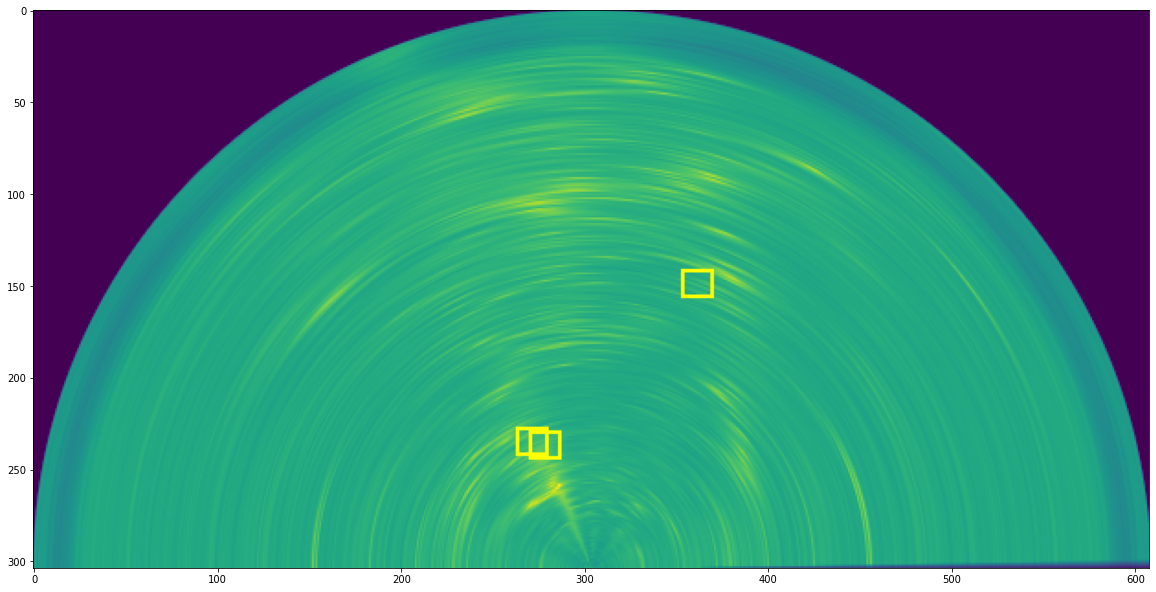

In [ ]:
rgb_beamformed = to_rgb_heatmap(rf.compute_range_azimuth(data['radar'][FRAME_IDX]), transform_fn=p2c_single)
projected_boxes = list(project_bounding_boxes(filtered_boxes, data['depth'][FRAME_IDX]))
annotated_radar = draw_boxes(rgb_beamformed, projected_boxes, show_labels=False)
plt.figure(figsize=(20,15))
plt.imshow(annotated_radar)
plt.show()